In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
import scipy.stats as stats
from tqdm import tqdm
from tabulate import tabulate
from numpy.random import multivariate_normal

### Objective functions

In [2]:
def Sphere(x):
    return np.sum(x**2)

def Griewank(x):
    part1 = np.sum(x**2)/4000
    part2 = np.prod(np.cos(x/np.sqrt(np.arange(1, len(x)+1))))
    return part1 - part2 + 1

def Rosenbrock(x):
    return np.sum(100*(x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

def Rastrigin(x):
    return 10*len(x) + np.sum(x**2 - 10*np.cos(2*np.pi*x))

def Ackley(x):
    a, b, c = 20, 0.2, 2 * np.pi
    d = len(x)
    part1 = -a * np.exp(-b * np.sqrt(np.sum(x ** 2) / d))
    part2 = -np.exp(np.sum(np.cos(c * x)) / d)
    return part1 + part2 + a + np.exp(1)


### Implementation of Algorithms

In [3]:
def de(obj_function, dimension, bounds, F_scale, pop_size, max_evals, cross_pop, seed, log_filename):
    log_file = log_filename
    with open(log_file, "w") as log:
        log.write(f"Algorithm: Differential Evolution\nObjective Function: {obj_function.__name__}\nDimension: {dimension}\nPopulation Size: {pop_size}\nMax Evaluations: {max_evals}\n\n")
        np.random.seed(seed)
        b_L, b_U = bounds
        pop = b_L + np.random.rand(pop_size, dimension) * (b_U - b_L)
        fitness = np.array([obj_function(x) for x in pop])
        num_eval = pop_size
        best_idx = np.argmin(fitness)
        best = pop[best_idx]
        results = [(np.copy(best), fitness[best_idx], num_eval)]
        pop_history = [np.copy(pop)]
        generation_count = 0
        log.write(f"Generation {generation_count}: Best Solution = {best}, Best Fitness = {fitness[best_idx]}, Evaluations = {num_eval}\n")
        while num_eval < max_evals:
            for i in range(pop_size):
                idxes = [idx for idx in range(pop_size) if idx != i]
                a, b, c = pop[np.random.choice(idxes, 3, replace=False)]
                mutant = np.clip(F_scale * (b - c) + a, b_L, b_U)
                cross_points = np.random.rand(dimension) < cross_pop
                if not np.any(cross_points):
                    cross_points[np.random.randint(0, dimension)] = True
                trial = np.where(cross_points, mutant, pop[i])
                f = obj_function(trial)
                num_eval += 1
                if f < fitness[i]:
                    pop[i] = trial
                    fitness[i] = f
                    if f < fitness[best_idx]:
                        best = trial
                        best_idx = i
            results.append((np.copy(best), fitness[best_idx], num_eval))
            pop_history.append(np.copy(pop))
            generation_count += 1
            log.write(f"Generation {generation_count}: Best Solution = {best}, Best Fitness = {fitness[best_idx]}, Evaluations = {num_eval}\n")
    
    return results, pop_history, generation_count

In [4]:
def cem(obj_function, dimension, bounds, pop_size, max_evals, elite_ratio, seed, log_filename):
    log_file = log_filename
    generation_count = 0
    np.random.seed(seed)
    b_L, b_U = bounds
    mean = np.random.uniform(b_L, b_U, dimension)
    cov_matrix = np.eye(dimension) * ((b_U - b_L) / 4) ** 2
    num_elite = int(pop_size * elite_ratio)
    num_eval = 0
    results = []
    pop_history = []

    ranks = np.arange(1, num_elite + 1)
    log_weights = np.log(num_elite + 1) - np.log(ranks)
    weights = log_weights / np.sum(log_weights)
    
    with open(log_file, "w") as log:
        log.write(f"Algorithm: Cross-Entropy Method\nObjective Function: {obj_function.__name__}\nDimension: {dimension}\nPopulation Size: {pop_size}\nMax Evaluations: {max_evals}\n\n")
    
        while num_eval < max_evals:
            generation_count += 1
            pop = multivariate_normal(mean, cov_matrix, size=pop_size)
            pop = np.clip(pop, b_L, b_U)
            fitness = np.array([obj_function(ind) for ind in pop])
            num_eval += pop_size
            
            elite_idx = np.argsort(fitness)[:num_elite]
            elite_samples = pop[elite_idx]
            
            mean = np.sum(weights[:, None] * elite_samples, axis=0)
            cov_matrix = np.sum(weights[:, None, None] * np.array([(z - mean)[:, None] @ (z - mean)[None, :] for z in elite_samples]), axis=0) + np.eye(dimension) * 1e-5
            
            best_idx = np.argmin(fitness)
            best_solution = pop[best_idx]
            best_fitness = fitness[best_idx]
            
            results.append((np.copy(best_solution), best_fitness, num_eval))
            pop_history.append(np.copy(pop))
            
            log.write(f"Generation {generation_count}: Best Solution = {best_solution}, Best Fitness = {best_fitness}, Evaluations = {num_eval}\n")
    
    return results, pop_history, generation_count

### Experiments

In [5]:
test_x_1 = np.array([1, 1])
print("Sphere:", Sphere(test_x_1))
print("Griewank:", Griewank(test_x_1))
print("Rosenbrock:", Rosenbrock(test_x_1))
print("Rastrigin:", Rastrigin(test_x_1))
print("Ackley:", Ackley(test_x_1))

Sphere: 2
Griewank: 0.5897380911762422
Rosenbrock: 0
Rastrigin: 2.0
Ackley: 3.6253849384403627


In [6]:
test_x_1 = np.array([0, 0])
print("Sphere:", Sphere(test_x_1))
print("Griewank:", Griewank(test_x_1))
print("Rosenbrock:", Rosenbrock(test_x_1))
print("Rastrigin:", Rastrigin(test_x_1))
print("Ackley:", Ackley(test_x_1))

Sphere: 0
Griewank: 0.0
Rosenbrock: 1
Rastrigin: 0.0
Ackley: 4.440892098500626e-16


#### Settings for experiment

In [7]:
bounds_dict = {
    "Sphere": (-5.12, 5.12),
    "Griewank": (-600, 600),
    "Rosenbrock": (-5, 10),
    "Rastrigin": (-5.12, 5.12),
    "Ackley": (-32.768, 32.768)
}

global_opt_dict = {
    "Sphere": (0, 0),
    "Griewank": (0, 0),
    "Rosenbrock": (1, 1),
    "Rastrigin": (0, 0),
    "Ackley": (0, 0)
}

In [8]:
def create_gif(algorithm_name, pop_history, obj_function, bounds, global_opt, filename):
    x = np.linspace(bounds[0], bounds[1], 100)
    y = np.linspace(bounds[0], bounds[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([[obj_function(np.array([xi, yi])) for xi, yi in zip(row_x, row_y)] for row_x, row_y in zip(X, Y)])

    images = []
    for i, pop in enumerate(pop_history):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.contourf(X, Y, Z, levels=100, cmap="viridis")
        ax.scatter(pop[:, 0], pop[:, 1], c='red', label=f'Generation {i}')
        ax.scatter(*global_opt, c='white', marker='*', s=100, label='Global Optimum')
        ax.legend()
        plt.title(f"{algorithm_name} Optimization Progress")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.savefig(f"frame_{i}.png")
        plt.close()
        images.append(imageio.imread(f"frame_{i}.png"))

    imageio.mimsave(filename, images, duration=1.1)
    for i in range(len(pop_history)):
        os.remove(f"frame_{i}.png")
    print(f"GIF saved as {filename}")


In [9]:
def read_log_file(log_filename):
    evaluations, fitness_values = [], []
    with open(log_filename, "r") as file:
        for line in file:
            if "Evaluations" in line and "Best Fitness" in line:
                parts = line.strip().split(",")
                fitness = float(parts[1].split("=")[1].strip())
                evals = int(parts[2].split("=")[1].strip())
                evaluations.append(evals)
                fitness_values.append(fitness)
    return evaluations, fitness_values

def plot_convergence_graph_from_logs(functions, pop_size, max_evals_dict):
    for obj_function in functions:
        print(obj_function.__name__)
        
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        for dim in [2, 10]:
            max_evals = max_evals_dict[dim]
            results_DE, results_CEM = [], []
            
            for seed in range(22520467, 22520477):
                log_filename_DE = f"logs/DE_{obj_function.__name__}_dim{dim}_pop{pop_size}_seed{seed}.log"
                log_filename_CEM = f"logs/CEM_{obj_function.__name__}_dim{dim}_pop{pop_size}_seed{seed}.log"

                if os.path.exists(log_filename_DE):
                    _, fitness_DE = read_log_file(log_filename_DE)
                    results_DE.append(fitness_DE)
                
                if os.path.exists(log_filename_CEM):
                    _, fitness_CEM = read_log_file(log_filename_CEM)
                    results_CEM.append(fitness_CEM)

            if results_DE and results_CEM:
                x_vals = np.linspace(0, max_evals, len(results_DE[0]))
                
                mean_DE = np.mean(results_DE, axis=0)
                std_DE = np.std(results_DE, axis=0)
                mean_CEM = np.mean(results_CEM, axis=0)
                std_CEM = np.std(results_CEM, axis=0)

                ax = axs[dim // 10]
                ax.plot(x_vals, mean_DE, '-', label=f"DE-{pop_size}", color='tab:red')
                ax.fill_between(x_vals, mean_DE - std_DE, mean_DE + std_DE, alpha=0.2, color='tab:red')
                # ax.plot(x_vals, mean_DE, 'o', color='tab:red')

                ax.plot(x_vals, mean_CEM, '-', label=f"CEM-{pop_size}", color='tab:blue')
                ax.fill_between(x_vals, mean_CEM - std_CEM, mean_CEM + std_CEM, alpha=0.2, color='tab:blue')
                # ax.plot(x_vals, mean_CEM, 'o', color='tab:blue')

                ax.set_xlabel("Number of Fitness Evaluations")
                ax.set_ylabel("Objective Function Value")
                ax.set_title(f"{obj_function.__name__} Convergence (d={dim})")
                ax.grid(True)
                ax.legend()

        plt.tight_layout() 
        plt.savefig(f"Convergence_{obj_function.__name__}_pop{pop_size}.png")
        plt.show()

In [10]:
def format_bold(text, is_bold=True):
    return f"\033[1m{text}\033[0m" if is_bold else text

def read_best_fitness(log_filename):
    best_fitness_values = []
    with open(log_filename, "r") as file:
        for line in file:
            if "Evaluations" in line and "Best Fitness" in line:
                parts = line.strip().split(",")
                fitness = float(parts[1].split("=")[1].strip())
                best_fitness_values.append(fitness)
    return best_fitness_values

def generate_statistics_table(functions, dims, pop_sizes):
    print("\nSignificance:")
    print("** : p-value < 0.01 (Highly Significant)")
    print("*  : 0.01 ≤ p-value < 0.05 (Significant)")
    print("NS : p-value ≥ 0.05 (Not Significant)")
    print("=" * 100)
    for obj_function in functions:
        for dim in dims:
            print(f"\nObjective Function: {obj_function.__name__} (d={dim})")
            print("=" * 100)
            
            # Tạo bảng dữ liệu
            table_data = []
            headers = [
                "Popsize N", 
                "DE (Mean ± Std)", 
                "CEM (Mean ± Std)", 
                "t-stat", 
                "p-value",
                "Significance"
            ]
            
            for pop_size in pop_sizes:
                results_DE, results_CEM = [], []
                
                for seed in range(22520467, 22520477):
                    log_filename_DE = f"logs/DE_{obj_function.__name__}_dim{dim}_pop{pop_size}_seed{seed}.log"
                    log_filename_CEM = f"logs/CEM_{obj_function.__name__}_dim{dim}_pop{pop_size}_seed{seed}.log"
                    
                    if os.path.exists(log_filename_DE):
                        results_DE.append(min(read_best_fitness(log_filename_DE)))
                    if os.path.exists(log_filename_CEM):
                        results_CEM.append(min(read_best_fitness(log_filename_CEM)))
                
                if results_DE and results_CEM:
                    mean_DE, std_DE = np.mean(results_DE), np.std(results_DE)
                    mean_CEM, std_CEM = np.mean(results_CEM), np.std(results_CEM)
                    
                    t_stat, p_value = stats.ttest_ind(results_DE, results_CEM, equal_var=False)
                    
                    # Xác định significance
                    if p_value < 0.01:
                        significance = "**"
                    elif p_value < 0.05:
                        significance = "*"
                    else:
                        significance = "NS"
                    
                    # Highlight kết quả tốt hơn
                    if mean_DE < mean_CEM:
                        de_str = format_bold(f"{mean_DE} ± {std_DE}")
                        cem_str = f"{mean_CEM} ± {std_CEM}"
                    else:
                        de_str = f"{mean_DE} ± {std_DE}"
                        cem_str = format_bold(f"{mean_CEM} ± {std_CEM}")
                    
                    table_data.append([
                        pop_size,
                        de_str,
                        cem_str,
                        f"{t_stat:.6f}",
                        f"{p_value:.6f}",
                        significance
                    ])
                else:
                    table_data.append([
                        pop_size,
                        "N/A",
                        "N/A",
                        "N/A",
                        "N/A",
                        "N/A"
                    ])
            
            # In bảng với định dạng đẹp
            print(tabulate(
                table_data, 
                headers=headers, 
                tablefmt="grid",
                stralign="center",
                numalign="center"
            ))
            print("=" * 100)

In [11]:
def run_experiments(algorithm_name, functions, pop_sizes, seeds, max_evals_dict, create_gif_flag=False):
    os.makedirs("logs/gifs", exist_ok=True)
    os.makedirs("gifs", exist_ok=True)

    for obj_function in tqdm(functions, desc="Running Experiments"):
        bounds = bounds_dict[obj_function.__name__]
        for dim in [2, 10]:
            max_evals = max_evals_dict[dim]
            for pop_size in pop_sizes:
                for seed in seeds:
                    log_filename = f"logs/{algorithm_name}_{obj_function.__name__}_dim{dim}_pop{pop_size}_seed{seed}.log"
                    if algorithm_name == "CEM":
                        cem(obj_function, dim, bounds, pop_size, max_evals, 0.5, seed, log_filename)
                    elif algorithm_name == "DE":
                        de(obj_function, dim, bounds, 0.7, pop_size, max_evals, 0.5, seed, log_filename)
                    print(f"Completed: {algorithm_name}_{obj_function.__name__}_dim{dim}_pop{pop_size}_seed{seed}")

    if create_gif_flag:
        max_evals = 5000
        for obj_function in tqdm(functions, desc="Creating GIFs"):
            bounds = bounds_dict[obj_function.__name__]
            global_opt = global_opt_dict[obj_function.__name__]
            for seed in [22520467]:
                log_filename_gif = f"logs/gifs/{algorithm_name.upper()}_{obj_function.__name__}_dim2_pop32_seed{seed}.log"
                
                results, pop_history, gen_count = None, None, None
                if algorithm_name == "CEM":
                    results, pop_history, gen_count = cem(obj_function, 2, bounds, 32, max_evals, 0.5, seed, log_filename_gif)
                elif algorithm_name == "DE":
                    results, pop_history, gen_count = de(obj_function, 2, bounds, 0.7, 32, max_evals, 0.5, seed, log_filename_gif)

                gif_filename = f"gifs/{algorithm_name.upper()}_{obj_function.__name__}_dim2_seed{seed}.gif"
                create_gif(algorithm_name, pop_history, obj_function, bounds, global_opt, filename=gif_filename)
                print(f"Saved GIF: {gif_filename}")

#### Run experiments

In [12]:
pop_sizes = [8, 16, 32, 64, 128]
functions = [Sphere, Griewank, Rosenbrock, Rastrigin, Ackley]
dims = [2, 10]
seeds = range(22520467, 22520477)
max_evals_dict = {2: 2000, 10: 10000}

In [13]:
run_experiments("DE", functions, pop_sizes, seeds, max_evals_dict, True)

Running Experiments:   0%|          | 0/5 [00:00<?, ?it/s]

Completed: DE_Sphere_dim2_pop8_seed22520467
Completed: DE_Sphere_dim2_pop8_seed22520468
Completed: DE_Sphere_dim2_pop8_seed22520469
Completed: DE_Sphere_dim2_pop8_seed22520470
Completed: DE_Sphere_dim2_pop8_seed22520471
Completed: DE_Sphere_dim2_pop8_seed22520472
Completed: DE_Sphere_dim2_pop8_seed22520473
Completed: DE_Sphere_dim2_pop8_seed22520474
Completed: DE_Sphere_dim2_pop8_seed22520475
Completed: DE_Sphere_dim2_pop8_seed22520476
Completed: DE_Sphere_dim2_pop16_seed22520467
Completed: DE_Sphere_dim2_pop16_seed22520468
Completed: DE_Sphere_dim2_pop16_seed22520469
Completed: DE_Sphere_dim2_pop16_seed22520470
Completed: DE_Sphere_dim2_pop16_seed22520471
Completed: DE_Sphere_dim2_pop16_seed22520472
Completed: DE_Sphere_dim2_pop16_seed22520473
Completed: DE_Sphere_dim2_pop16_seed22520474
Completed: DE_Sphere_dim2_pop16_seed22520475
Completed: DE_Sphere_dim2_pop16_seed22520476
Completed: DE_Sphere_dim2_pop32_seed22520467
Completed: DE_Sphere_dim2_pop32_seed22520468
Completed: DE_Sphere

Running Experiments:  20%|██        | 1/5 [00:28<01:53, 28.33s/it]

Completed: DE_Sphere_dim10_pop128_seed22520476
Completed: DE_Griewank_dim2_pop8_seed22520467
Completed: DE_Griewank_dim2_pop8_seed22520468
Completed: DE_Griewank_dim2_pop8_seed22520469
Completed: DE_Griewank_dim2_pop8_seed22520470
Completed: DE_Griewank_dim2_pop8_seed22520471
Completed: DE_Griewank_dim2_pop8_seed22520472
Completed: DE_Griewank_dim2_pop8_seed22520473
Completed: DE_Griewank_dim2_pop8_seed22520474
Completed: DE_Griewank_dim2_pop8_seed22520475
Completed: DE_Griewank_dim2_pop8_seed22520476
Completed: DE_Griewank_dim2_pop16_seed22520467
Completed: DE_Griewank_dim2_pop16_seed22520468
Completed: DE_Griewank_dim2_pop16_seed22520469
Completed: DE_Griewank_dim2_pop16_seed22520470
Completed: DE_Griewank_dim2_pop16_seed22520471
Completed: DE_Griewank_dim2_pop16_seed22520472
Completed: DE_Griewank_dim2_pop16_seed22520473
Completed: DE_Griewank_dim2_pop16_seed22520474
Completed: DE_Griewank_dim2_pop16_seed22520475
Completed: DE_Griewank_dim2_pop16_seed22520476
Completed: DE_Griewank_

Running Experiments:  40%|████      | 2/5 [01:01<01:33, 31.33s/it]

Completed: DE_Griewank_dim10_pop128_seed22520476
Completed: DE_Rosenbrock_dim2_pop8_seed22520467
Completed: DE_Rosenbrock_dim2_pop8_seed22520468
Completed: DE_Rosenbrock_dim2_pop8_seed22520469
Completed: DE_Rosenbrock_dim2_pop8_seed22520470
Completed: DE_Rosenbrock_dim2_pop8_seed22520471
Completed: DE_Rosenbrock_dim2_pop8_seed22520472
Completed: DE_Rosenbrock_dim2_pop8_seed22520473
Completed: DE_Rosenbrock_dim2_pop8_seed22520474
Completed: DE_Rosenbrock_dim2_pop8_seed22520475
Completed: DE_Rosenbrock_dim2_pop8_seed22520476
Completed: DE_Rosenbrock_dim2_pop16_seed22520467
Completed: DE_Rosenbrock_dim2_pop16_seed22520468
Completed: DE_Rosenbrock_dim2_pop16_seed22520469
Completed: DE_Rosenbrock_dim2_pop16_seed22520470
Completed: DE_Rosenbrock_dim2_pop16_seed22520471
Completed: DE_Rosenbrock_dim2_pop16_seed22520472
Completed: DE_Rosenbrock_dim2_pop16_seed22520473
Completed: DE_Rosenbrock_dim2_pop16_seed22520474
Completed: DE_Rosenbrock_dim2_pop16_seed22520475
Completed: DE_Rosenbrock_dim2_

Running Experiments:  60%|██████    | 3/5 [01:33<01:02, 31.36s/it]

Completed: DE_Rosenbrock_dim10_pop128_seed22520476
Completed: DE_Rastrigin_dim2_pop8_seed22520467
Completed: DE_Rastrigin_dim2_pop8_seed22520468
Completed: DE_Rastrigin_dim2_pop8_seed22520469
Completed: DE_Rastrigin_dim2_pop8_seed22520470
Completed: DE_Rastrigin_dim2_pop8_seed22520471
Completed: DE_Rastrigin_dim2_pop8_seed22520472
Completed: DE_Rastrigin_dim2_pop8_seed22520473
Completed: DE_Rastrigin_dim2_pop8_seed22520474
Completed: DE_Rastrigin_dim2_pop8_seed22520475
Completed: DE_Rastrigin_dim2_pop8_seed22520476
Completed: DE_Rastrigin_dim2_pop16_seed22520467
Completed: DE_Rastrigin_dim2_pop16_seed22520468
Completed: DE_Rastrigin_dim2_pop16_seed22520469
Completed: DE_Rastrigin_dim2_pop16_seed22520470
Completed: DE_Rastrigin_dim2_pop16_seed22520471
Completed: DE_Rastrigin_dim2_pop16_seed22520472
Completed: DE_Rastrigin_dim2_pop16_seed22520473
Completed: DE_Rastrigin_dim2_pop16_seed22520474
Completed: DE_Rastrigin_dim2_pop16_seed22520475
Completed: DE_Rastrigin_dim2_pop16_seed22520476

Running Experiments:  80%|████████  | 4/5 [02:03<00:31, 31.10s/it]

Completed: DE_Rastrigin_dim10_pop128_seed22520476
Completed: DE_Ackley_dim2_pop8_seed22520467
Completed: DE_Ackley_dim2_pop8_seed22520468
Completed: DE_Ackley_dim2_pop8_seed22520469
Completed: DE_Ackley_dim2_pop8_seed22520470
Completed: DE_Ackley_dim2_pop8_seed22520471
Completed: DE_Ackley_dim2_pop8_seed22520472
Completed: DE_Ackley_dim2_pop8_seed22520473
Completed: DE_Ackley_dim2_pop8_seed22520474
Completed: DE_Ackley_dim2_pop8_seed22520475
Completed: DE_Ackley_dim2_pop8_seed22520476
Completed: DE_Ackley_dim2_pop16_seed22520467
Completed: DE_Ackley_dim2_pop16_seed22520468
Completed: DE_Ackley_dim2_pop16_seed22520469
Completed: DE_Ackley_dim2_pop16_seed22520470
Completed: DE_Ackley_dim2_pop16_seed22520471
Completed: DE_Ackley_dim2_pop16_seed22520472
Completed: DE_Ackley_dim2_pop16_seed22520473
Completed: DE_Ackley_dim2_pop16_seed22520474
Completed: DE_Ackley_dim2_pop16_seed22520475
Completed: DE_Ackley_dim2_pop16_seed22520476
Completed: DE_Ackley_dim2_pop32_seed22520467
Completed: DE_A

Running Experiments: 100%|██████████| 5/5 [02:38<00:00, 31.79s/it]


Completed: DE_Ackley_dim10_pop128_seed22520476


Creating GIFs:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\Legion 5 Pro\AppData\Local\Temp\ipykernel_15472\2882844591.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"frame_{i}.png"))
Creating GIFs:  20%|██        | 1/5 [00:29<01:57, 29.31s/it]

GIF saved as gifs/DE_Sphere_dim2_seed22520467.gif
Saved GIF: gifs/DE_Sphere_dim2_seed22520467.gif


Creating GIFs:  40%|████      | 2/5 [01:00<01:31, 30.63s/it]

GIF saved as gifs/DE_Griewank_dim2_seed22520467.gif
Saved GIF: gifs/DE_Griewank_dim2_seed22520467.gif


Creating GIFs:  60%|██████    | 3/5 [01:30<01:00, 30.04s/it]

GIF saved as gifs/DE_Rosenbrock_dim2_seed22520467.gif
Saved GIF: gifs/DE_Rosenbrock_dim2_seed22520467.gif


Creating GIFs:  80%|████████  | 4/5 [02:20<00:38, 38.04s/it]

GIF saved as gifs/DE_Rastrigin_dim2_seed22520467.gif
Saved GIF: gifs/DE_Rastrigin_dim2_seed22520467.gif


Creating GIFs: 100%|██████████| 5/5 [03:06<00:00, 37.20s/it]

GIF saved as gifs/DE_Ackley_dim2_seed22520467.gif
Saved GIF: gifs/DE_Ackley_dim2_seed22520467.gif


In [14]:
run_experiments("CEM", functions, pop_sizes, seeds, max_evals_dict, True)

Running Experiments:   0%|          | 0/5 [00:00<?, ?it/s]

Completed: CEM_Sphere_dim2_pop8_seed22520467
Completed: CEM_Sphere_dim2_pop8_seed22520468
Completed: CEM_Sphere_dim2_pop8_seed22520469
Completed: CEM_Sphere_dim2_pop8_seed22520470
Completed: CEM_Sphere_dim2_pop8_seed22520471
Completed: CEM_Sphere_dim2_pop8_seed22520472
Completed: CEM_Sphere_dim2_pop8_seed22520473
Completed: CEM_Sphere_dim2_pop8_seed22520474
Completed: CEM_Sphere_dim2_pop8_seed22520475
Completed: CEM_Sphere_dim2_pop8_seed22520476
Completed: CEM_Sphere_dim2_pop16_seed22520467
Completed: CEM_Sphere_dim2_pop16_seed22520468
Completed: CEM_Sphere_dim2_pop16_seed22520469
Completed: CEM_Sphere_dim2_pop16_seed22520470
Completed: CEM_Sphere_dim2_pop16_seed22520471
Completed: CEM_Sphere_dim2_pop16_seed22520472
Completed: CEM_Sphere_dim2_pop16_seed22520473
Completed: CEM_Sphere_dim2_pop16_seed22520474
Completed: CEM_Sphere_dim2_pop16_seed22520475
Completed: CEM_Sphere_dim2_pop16_seed22520476
Completed: CEM_Sphere_dim2_pop32_seed22520467
Completed: CEM_Sphere_dim2_pop32_seed2252046

Running Experiments:  20%|██        | 1/5 [00:10<00:40, 10.20s/it]

Completed: CEM_Sphere_dim10_pop128_seed22520475
Completed: CEM_Sphere_dim10_pop128_seed22520476
Completed: CEM_Griewank_dim2_pop8_seed22520467
Completed: CEM_Griewank_dim2_pop8_seed22520468
Completed: CEM_Griewank_dim2_pop8_seed22520469
Completed: CEM_Griewank_dim2_pop8_seed22520470
Completed: CEM_Griewank_dim2_pop8_seed22520471
Completed: CEM_Griewank_dim2_pop8_seed22520472
Completed: CEM_Griewank_dim2_pop8_seed22520473
Completed: CEM_Griewank_dim2_pop8_seed22520474
Completed: CEM_Griewank_dim2_pop8_seed22520475
Completed: CEM_Griewank_dim2_pop8_seed22520476
Completed: CEM_Griewank_dim2_pop16_seed22520467
Completed: CEM_Griewank_dim2_pop16_seed22520468
Completed: CEM_Griewank_dim2_pop16_seed22520469
Completed: CEM_Griewank_dim2_pop16_seed22520470
Completed: CEM_Griewank_dim2_pop16_seed22520471
Completed: CEM_Griewank_dim2_pop16_seed22520472
Completed: CEM_Griewank_dim2_pop16_seed22520473
Completed: CEM_Griewank_dim2_pop16_seed22520474
Completed: CEM_Griewank_dim2_pop16_seed22520475
Co

Running Experiments:  40%|████      | 2/5 [00:24<00:37, 12.65s/it]

Completed: CEM_Griewank_dim10_pop128_seed22520476
Completed: CEM_Rosenbrock_dim2_pop8_seed22520467
Completed: CEM_Rosenbrock_dim2_pop8_seed22520468
Completed: CEM_Rosenbrock_dim2_pop8_seed22520469
Completed: CEM_Rosenbrock_dim2_pop8_seed22520470
Completed: CEM_Rosenbrock_dim2_pop8_seed22520471
Completed: CEM_Rosenbrock_dim2_pop8_seed22520472
Completed: CEM_Rosenbrock_dim2_pop8_seed22520473
Completed: CEM_Rosenbrock_dim2_pop8_seed22520474
Completed: CEM_Rosenbrock_dim2_pop8_seed22520475
Completed: CEM_Rosenbrock_dim2_pop8_seed22520476
Completed: CEM_Rosenbrock_dim2_pop16_seed22520467
Completed: CEM_Rosenbrock_dim2_pop16_seed22520468
Completed: CEM_Rosenbrock_dim2_pop16_seed22520469
Completed: CEM_Rosenbrock_dim2_pop16_seed22520470
Completed: CEM_Rosenbrock_dim2_pop16_seed22520471
Completed: CEM_Rosenbrock_dim2_pop16_seed22520472
Completed: CEM_Rosenbrock_dim2_pop16_seed22520473
Completed: CEM_Rosenbrock_dim2_pop16_seed22520474
Completed: CEM_Rosenbrock_dim2_pop16_seed22520475
Completed:

Running Experiments:  60%|██████    | 3/5 [00:37<00:25, 12.90s/it]

Completed: CEM_Rosenbrock_dim10_pop128_seed22520476
Completed: CEM_Rastrigin_dim2_pop8_seed22520467
Completed: CEM_Rastrigin_dim2_pop8_seed22520468
Completed: CEM_Rastrigin_dim2_pop8_seed22520469
Completed: CEM_Rastrigin_dim2_pop8_seed22520470
Completed: CEM_Rastrigin_dim2_pop8_seed22520471
Completed: CEM_Rastrigin_dim2_pop8_seed22520472
Completed: CEM_Rastrigin_dim2_pop8_seed22520473
Completed: CEM_Rastrigin_dim2_pop8_seed22520474
Completed: CEM_Rastrigin_dim2_pop8_seed22520475
Completed: CEM_Rastrigin_dim2_pop8_seed22520476
Completed: CEM_Rastrigin_dim2_pop16_seed22520467
Completed: CEM_Rastrigin_dim2_pop16_seed22520468
Completed: CEM_Rastrigin_dim2_pop16_seed22520469
Completed: CEM_Rastrigin_dim2_pop16_seed22520470
Completed: CEM_Rastrigin_dim2_pop16_seed22520471
Completed: CEM_Rastrigin_dim2_pop16_seed22520472
Completed: CEM_Rastrigin_dim2_pop16_seed22520473
Completed: CEM_Rastrigin_dim2_pop16_seed22520474
Completed: CEM_Rastrigin_dim2_pop16_seed22520475
Completed: CEM_Rastrigin_di

Running Experiments:  80%|████████  | 4/5 [00:50<00:12, 12.73s/it]

Completed: CEM_Rastrigin_dim10_pop128_seed22520476
Completed: CEM_Ackley_dim2_pop8_seed22520467
Completed: CEM_Ackley_dim2_pop8_seed22520468
Completed: CEM_Ackley_dim2_pop8_seed22520469
Completed: CEM_Ackley_dim2_pop8_seed22520470
Completed: CEM_Ackley_dim2_pop8_seed22520471
Completed: CEM_Ackley_dim2_pop8_seed22520472
Completed: CEM_Ackley_dim2_pop8_seed22520473
Completed: CEM_Ackley_dim2_pop8_seed22520474
Completed: CEM_Ackley_dim2_pop8_seed22520475
Completed: CEM_Ackley_dim2_pop8_seed22520476
Completed: CEM_Ackley_dim2_pop16_seed22520467
Completed: CEM_Ackley_dim2_pop16_seed22520468
Completed: CEM_Ackley_dim2_pop16_seed22520469
Completed: CEM_Ackley_dim2_pop16_seed22520470
Completed: CEM_Ackley_dim2_pop16_seed22520471
Completed: CEM_Ackley_dim2_pop16_seed22520472
Completed: CEM_Ackley_dim2_pop16_seed22520473
Completed: CEM_Ackley_dim2_pop16_seed22520474
Completed: CEM_Ackley_dim2_pop16_seed22520475
Completed: CEM_Ackley_dim2_pop16_seed22520476
Completed: CEM_Ackley_dim2_pop32_seed22

Running Experiments: 100%|██████████| 5/5 [01:06<00:00, 13.27s/it]


Completed: CEM_Ackley_dim10_pop128_seed22520476


Creating GIFs:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\Legion 5 Pro\AppData\Local\Temp\ipykernel_15472\2882844591.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"frame_{i}.png"))
Creating GIFs:  20%|██        | 1/5 [00:31<02:06, 31.57s/it]

GIF saved as gifs/CEM_Sphere_dim2_seed22520467.gif
Saved GIF: gifs/CEM_Sphere_dim2_seed22520467.gif


Creating GIFs:  40%|████      | 2/5 [01:02<01:33, 31.07s/it]

GIF saved as gifs/CEM_Griewank_dim2_seed22520467.gif
Saved GIF: gifs/CEM_Griewank_dim2_seed22520467.gif


Creating GIFs:  60%|██████    | 3/5 [01:29<00:58, 29.46s/it]

GIF saved as gifs/CEM_Rosenbrock_dim2_seed22520467.gif
Saved GIF: gifs/CEM_Rosenbrock_dim2_seed22520467.gif


Creating GIFs:  80%|████████  | 4/5 [02:19<00:37, 37.51s/it]

GIF saved as gifs/CEM_Rastrigin_dim2_seed22520467.gif
Saved GIF: gifs/CEM_Rastrigin_dim2_seed22520467.gif


Creating GIFs: 100%|██████████| 5/5 [03:03<00:00, 36.75s/it]

GIF saved as gifs/CEM_Ackley_dim2_seed22520467.gif
Saved GIF: gifs/CEM_Ackley_dim2_seed22520467.gif


Sphere


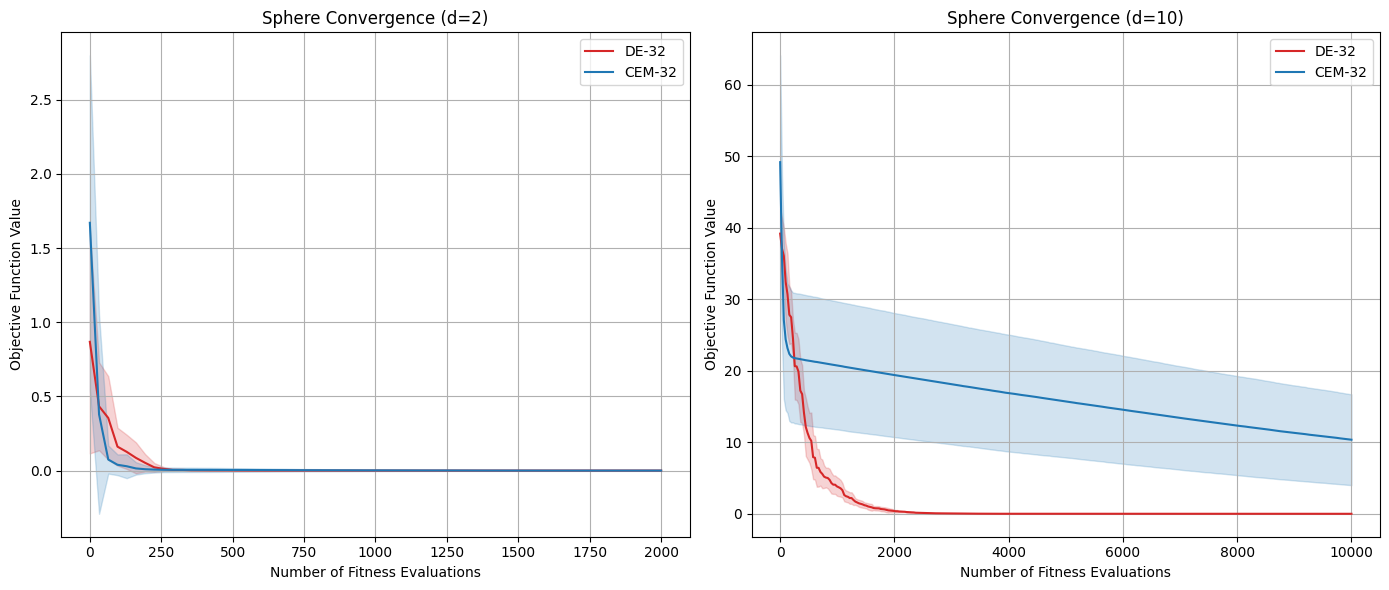

Griewank


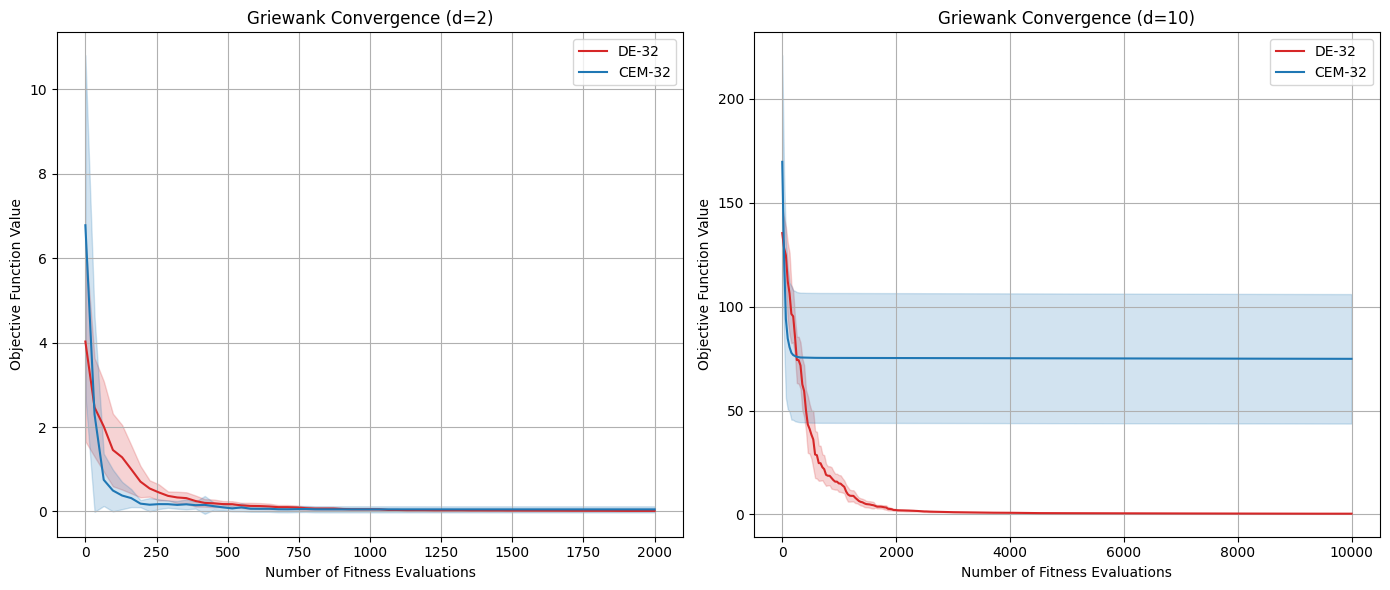

Rosenbrock


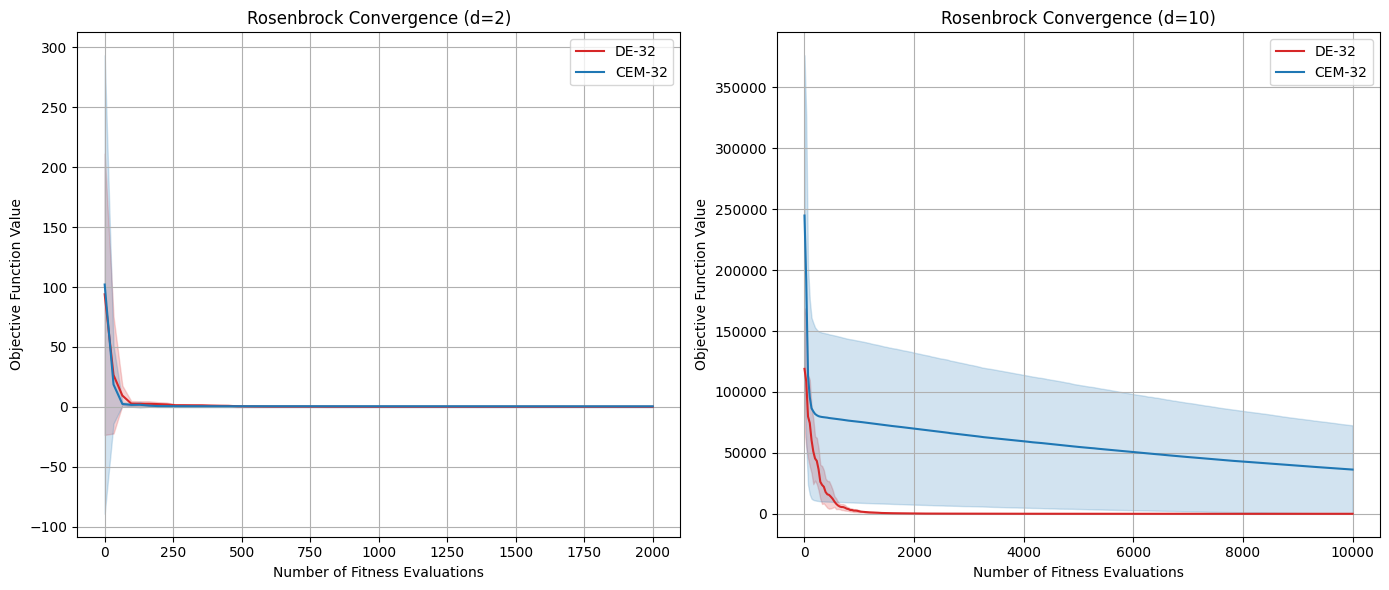

Rastrigin


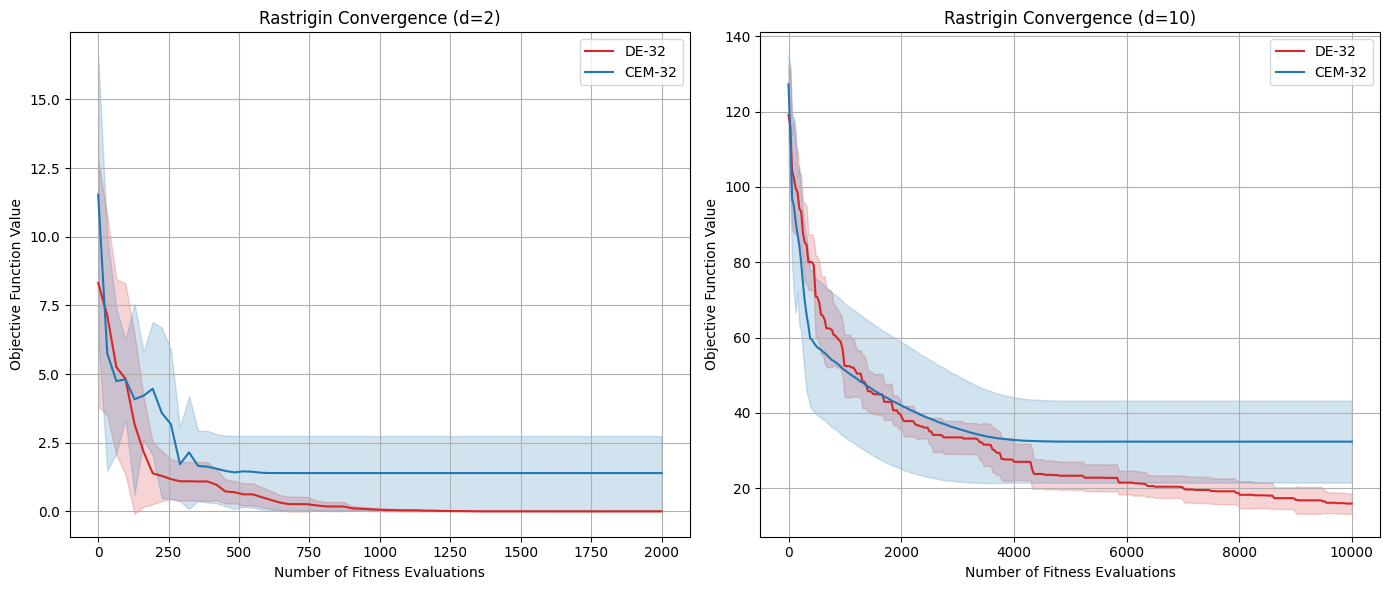

Ackley


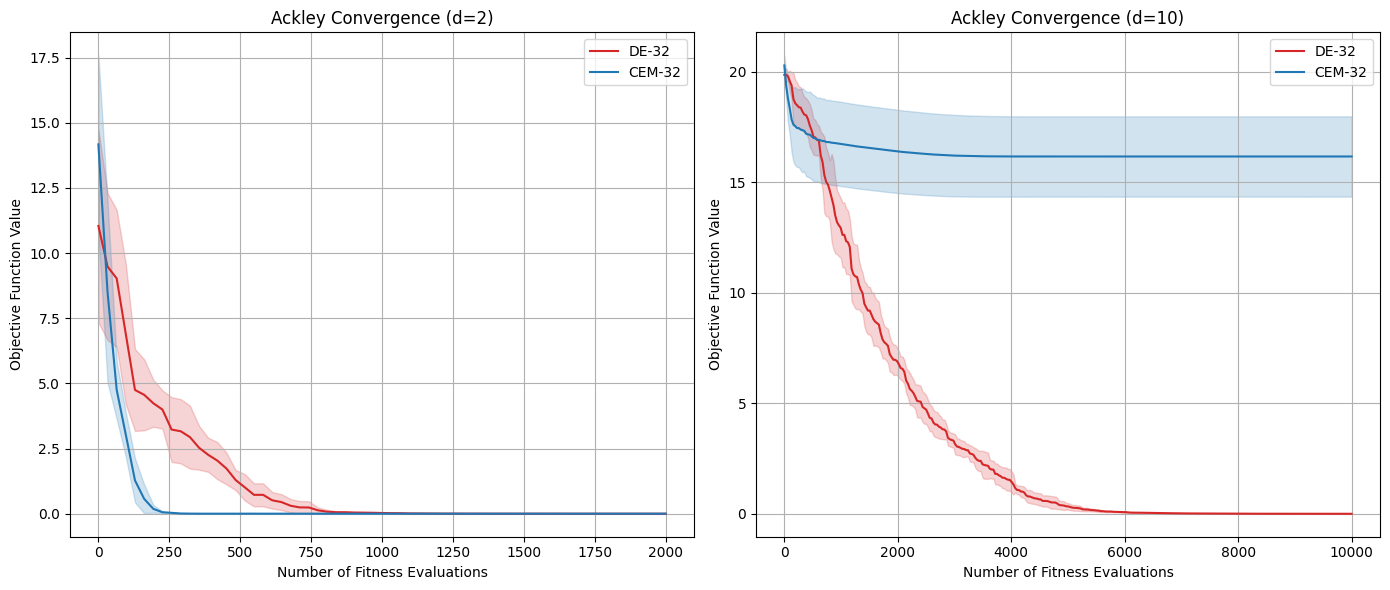

In [15]:
plot_convergence_graph_from_logs(functions, 32, max_evals_dict)

In [16]:
generate_statistics_table(functions, dims, pop_sizes)


Significance:
** : p-value < 0.01 (Highly Significant)
*  : 0.01 ≤ p-value < 0.05 (Significant)
NS : p-value ≥ 0.05 (Not Significant)

Objective Function: Sphere (d=2)
+-------------+------------------------------------------------+-------------------------------------------------+----------+-----------+----------------+
|  Popsize N  |                DE (Mean ± Std)                 |                CEM (Mean ± Std)                 |  t-stat  |  p-value  |  Significance  |
+=============+================================================+=================================================+==========+===========+================+
|      8      | 2.4847329464237757e-48 ± 7.270755740678101e-48 |     3.1980496713291595 ± 4.920272440293379      | -1.94992 | 0.082977  |       NS       |
+-------------+------------------------------------------------+-------------------------------------------------+----------+-----------+----------------+
|     16      | 1.9766190255644683e-24 ± 5.3334530220214

### Analysis

1. Kết quả thực nghiệm

    **DE (Differential Evolution)**

    Ưu điểm:
    - Hiệu quả cao trên hàm đơn giản (Sphere, Ackley) với kết quả ≈0 ở mọi kích thước quần thể
    - Xử lý tốt các hàm đa cực trị (Rastrigin, Griewank), vượt trội hơn CEM 10-100 lần
    - Thích ứng tốt với bài toán nhiều chiều (d=10) ngay cả khi quần thể nhỏ (8-32 cá thể)

    Nhược điểm:
    - Hiệu suất giảm trên Rosenbrock d=2 (cần popsize lớn để cạnh tranh với CEM)

    **CEM (Cross-Entropy Method)**

    Ưu điểm:
    - Thể hiện khả năng tốt trên Rosenbrock d=2 khi quần thể ≥128

    Nhược điểm:
    - Có hiệu quả kém rõ rệt ở bài toán nhiều chiều (d=10) - thường xuyên mắc kẹt cực trị địa phương (local minima)
    - Độ ổn định thấp (độ lệch chuẩn lên tới 40512.91)
    - Yêu cầu popsize lớn để đạt kết quả khả quan hơn

2. Kết luận chung

    | Thuật toán | Ưu điểm | Nhược điểm | Phù hợp |
    |------------|---------|------------|---------|
    | **DE** | Hiệu suất cao, ổn định | Kém hiệu quả trên Rosenbrock d=2 | Hầu hết bài toán |
    | **CEM** | Tốt trên Rosenbrock d=2 | Kém ổn định, yêu cầu quần thể lớn | Bài toán đơn giản |


*Kết quả dựa trên 5 hàm benchmark với số chiều d=2/d=10, với các seed từ 22520467 - 22520476, kích thước quần thể 8-128 cá thể*